# End-to-End Automated Learning to Rank

This notebook contains every step from Chapters 10 and 11, to give you a sandbox to explore tuning a fully automated LTR system.

In [3]:
import numpy
from aips import *
from ltr.sdbn_functions import all_sessions

import aips.indexer
aips.indexer.pull_github_repository("signals")

## Load every session we have data for

load every session we have data for as the raw session clickstream data (what was returned, clicked, and not clicked)

In [4]:
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,transformers dark of the moon,0.0,47875842328,False
1,2,transformers dark of the moon,1.0,24543701538,True
2,2,transformers dark of the moon,2.0,25192107191,False
3,2,transformers dark of the moon,3.0,47875841420,False
4,2,transformers dark of the moon,4.0,786936817218,False
...,...,...,...,...,...
149995,60001,bluray,25.0,23942973416,False
149996,60001,bluray,26.0,25192107191,False
149997,60001,bluray,27.0,27242809710,False
149998,60001,bluray,28.0,600603132872,False


## SDBN Judgments using Beta Distribution

We have about a dozen queries where we've simulated the click stream. Here we compute the SDBN judgments, using a beta distribution, on each of these queries. The code in `generate_training_data` just repeats what we did in this section of the book, just for every query we have data for. 

We then convert these to the `Judgments` object we use in Chapter 10

### What you should play with

Explore the strength of the prior (`PRIOR_WEIGHT`) as well as the specific default relevance grade, `PRIOR_GRADE`. A stronger `PRIOR_WEIGHT` won't budge much from `PRIOR_WEIGHT`.

If you're feeling more advanced, you can explore different methods of computing the relevance judgments from these sessions, by replacing `sessions_to_sdbn` with your own formula for translating clicks to judgments.

In [5]:
PRIOR_GRADE=0.2
PRIOR_WEIGHT=10

from ltr.judgments import Judgment

# Create a judgment list with our queries
def sessions_to_sdbn(query):
    """ Compute SDBN of the provided query as a dataframe.
        Where we left off at end of 'overcoming confidence bias' 
        """
    sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')

    last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

    sdbn_sessions['last_click_rank'] = last_click_per_session
    sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

    sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
    sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

    sdbn = sdbn.sort_values('grade', ascending=False)

    sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
    sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

    sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
    sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

    sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

    sdbn.sort_values('beta_grade', ascending=False)
    return sdbn


def sdbn_to_judgments(sdbn, query, qid):
    judgments = []
    for row_dict in sdbn.reset_index().to_dict(orient="records"):
        # Round grade to 10ths, Map 0.3 -> 3, etc
        grade = round(row_dict['beta_grade'], 1) * 10
        judgments.append(Judgment(doc_id=row_dict['doc_id'],
                                  keywords=query,
                                  qid=qid,
                                  grade=int(grade))
                        )
    return judgments


simulated_queries = ['dryer', 'bluray', 'blue ray', 'headphones', 'ipad', 'iphone',
                     'kindle', 'lcd tv', 'macbook', 'nook', 'star trek', 'star wars',
                     'transformers dark of the moon']



judgments = []
for qid, query in enumerate(simulated_queries):
    sdbn = sessions_to_sdbn(query)
    judgments.extend(sdbn_to_judgments(sdbn, query, qid))
    
    
judgments

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[],weight=1),
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=74108096487,features=[],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=36725561977,features=[],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=84691226703,features=[],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=665331101927,features=[],weight=1),
 Judgment(grade=2,qid=0,ke

In [6]:
from ltr.judgments import judgments_to_file

judgments_to_file(open('data/product_judgments.txt', 'w'), judgments)

In [7]:
sessions_to_sdbn('dryer')

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
856751002097,133,323,0.411765,2.0,8.0,135.0,198.0,0.405405
48231011396,166,423,0.392435,2.0,8.0,168.0,265.0,0.387991
84691226727,804,2541,0.316411,2.0,8.0,806.0,1745.0,0.315955
74108007469,208,708,0.293785,2.0,8.0,210.0,508.0,0.292479
12505525766,268,974,0.275154,2.0,8.0,270.0,714.0,0.274390
36725578241,130,477,0.272537,2.0,8.0,132.0,355.0,0.271047
48231011402,213,818,0.260391,2.0,8.0,215.0,613.0,0.259662
12505527456,110,428,0.257009,2.0,8.0,112.0,326.0,0.255708
74108096487,235,1097,0.214221,2.0,8.0,237.0,870.0,0.214092


## Index Retrotech

Index retrotech data into Solr. 

### What you should play with:

- What new fields besides these would be useful to use as features?
- What work could you do to these fields to help with relevance?

**Note - You can safely ignore any errors deleting / readding the LTR query parser**

In [8]:
import sys
sys.path.append('../..')
from aips import *
import os
from IPython.display import display,HTML
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("aips-ch11-getting-started-retrotech").getOrCreate()

#Create Products Collection
products_collection="products"
create_collection(products_collection)
get_ltr_engine(products_collection).enable_ltr()

#Modify Schema to make some fields explicitly searchable by keyword
upsert_text_field(products_collection, "upc")
upsert_text_field(products_collection, "name")
upsert_text_field(products_collection, "long_description")
upsert_text_field(products_collection, "short_description")
upsert_text_field(products_collection, "manufacturer")

print("Loading Products...")
csvFile = "data/retrotech/products.csv"
product_update_opts={"zkhost": "aips-zk", "collection": products_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
csvDF = spark.read.csv(csvFile, header=True, inferSchema=True)
csvDF.write.format("solr").options(**product_update_opts).mode("overwrite").save()
print("Products Schema: ")
csvDF.printSchema()
print("Status: Success")

Wiping 'products' collection
[('action', 'CREATE'), ('name', 'products'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'products' collection
Status: Success
Del/Adding LTR QParser for products collection
<Response [400]>
Status: Failure; Response:[ {'responseHeader': {'status': 400, 'QTime': 1}, 'errorMessages': ["error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], \n"], 'WARNING': 'This response format is experimental.  It is likely to change in the future.', 'error': {'metadata': ['error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject', 'root-error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject'], 'details': [{'delete-queryparser': 'ltr', 'errorMessages': ["NO such queryParser 'ltr' "]}], 'msg': "error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], ", 'code': 400}} ]
Status: Success
Adding LTR Doc Transformer for products collection
Status: Failu

## Create a simple feature set

Here's a simple feature set. The ranking function can _only be as good as the training data and features_.

### What you should play with:

Experiment with different features to see what builds the most robust model.

In [9]:

resp = requests.delete(f"{SOLR_URL}/{products_collection}/schema/feature-store/test")

import requests

feature_set = [
    {
      "name" : "name_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "name:(${keywords})"
      }
    },
    {
      "name" : "name_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "name:(${keywords})^=1"
      }
    }
]

# Some extra features to explore
"""
    {
      "name" : "longDesciption_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "long_description:(${keywords})"
      }
    },
    {
      "name" : "shortDesciption_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "short_description:(${keywords})"
      }
    },
    {
      "name" : "short_description_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "short_description:(${keywords})^=1"
      }
    },
    {
      "name" : "long_description_constant",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { #q=title:({$keywords})
        "q" : "long_description:(${keywords})^=1"
      }
    },
    {
      "name" : "longDesciptionPhrase_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "long_description:\"${keywords}\""
      }
    },
    {
      "name" : "shortDesciptionPhrase_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "short_description:\"${keywords}\""
      }
    },
    {
      "name":  "nameLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "name"
      }
    },
    {
      "name":  "short_descriptionLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "short_description"
      }
    },
    {
      "name":  "long_descriptionLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "long_description"
      }
    },
    {
      "name":  "manufacturerLength",
      "store": "test",
      "class": "org.apache.solr.ltr.feature.FieldLengthFeature",
      "params": {
          "field": "long_description"
      }
    }
"""

resp = requests.post(f"{SOLR_URL}/{products_collection}/schema/feature-store",
                     json=feature_set)
resp, resp.text

(<Response [200]>,
 '{\n  "responseHeader":{\n    "status":0,\n    "QTime":2}}\n')

In [10]:
resp = requests.get(f"{SOLR_URL}/solr/{products_collection}/schema/feature-store/test")
products_collection

'products'

In [11]:
!cat data/product_judgments.txt

# qid:0: dryer*1
# qid:1: bluray*1
# qid:2: blue ray*1
# qid:3: headphones*1
# qid:4: ipad*1
# qid:5: iphone*1
# qid:6: kindle*1
# qid:7: lcd tv*1
# qid:8: macbook*1
# qid:9: nook*1
# qid:10: star trek*1
# qid:11: star wars*1
# qid:12: transformers dark of the moon*1

4	qid:0	 # 856751002097	dryer
4	qid:0	 # 48231011396	dryer
3	qid:0	 # 84691226727	dryer
3	qid:0	 # 74108007469	dryer
3	qid:0	 # 12505525766	dryer
3	qid:0	 # 36725578241	dryer
3	qid:0	 # 48231011402	dryer
3	qid:0	 # 12505527456	dryer
2	qid:0	 # 74108096487	dryer
2	qid:0	 # 36725561977	dryer
2	qid:0	 # 84691226703	dryer
2	qid:0	 # 665331101927	dryer
2	qid:0	 # 783722274422	dryer
2	qid:0	 # 14381196320	dryer
2	qid:0	 # 77283045400	dryer
2	qid:0	 # 74108056764	dryer
1	qid:0	 # 883049066905	dryer
1	qid:0	 # 12505451713	dryer
1	qid:0	 # 36172950027	dryer
1	qid:0	 # 883929085118	dryer
9	qid:1	 # 600603141003	bluray
5	qid:1	 # 27242813908	bluray
5	qid:1	 # 600603132872	bluray
2	qid:1	 # 36725608894	bluray
2	qid:1	 # 25192107191	b

## Log features from Solr

Log all the features to hydrate the judgmenst list. There's not too much to play with here, this is just code we need to build our training set.

In [12]:
from ltr.log import FeatureLogger
from ltr.judgments import judgments_open
from itertools import groupby
from ltr import download

ftr_logger=FeatureLogger(index='products', feature_set='test', id_field='upc')

with judgments_open('data/product_judgments.txt') as judgment_list:
    for qid, query_judgments in groupby(judgments, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with title_bm25, overview_bm25, and release_year 
# logged out
logged_judgments

{!terms f=upc}856751002097,48231011396,84691226727,74108007469,12505525766,36725578241,48231011402,12505527456,74108096487,36725561977,84691226703,665331101927,783722274422,14381196320,77283045400,74108056764,883049066905,12505451713,36172950027,883929085118
Searching products [Status: 200]
{!terms f=upc}600603141003,27242813908,600603132872,36725608894,25192107191,36725608511,605342041546,883929140855,786936817232,22265004517,719192580374,24543742180,36725608443,23942973416,36725617605,27242815414,826663129342,58231306590,27242809758,36725608436,36725617506,711719983156,186156000290,58231300826,23942972389,786936805017,25192073007,885170038875,711719804604,27242809710
Searching products [Status: 200]
Missing doc 600603141003
Missing doc 600603132872
{!terms f=upc}27242815414,600603132872,827396513927,600603141003,885170033412,883929140855,24543672067,813774010904,36725617605,786936817232,36725608443,719192580374,25192073007,75993997675,36725608894,786936817218,711719983156,22265052211

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[2.9048662, 1.0],weight=1),
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[0.0, 0.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[2.443951, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[2.3211834, 1.0],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[2.1092727, 1.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=74108096487,features=[2.21016, 1.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=36725561977,features=[0.0, 0.0],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id=84691226703,featur

## Normalize features

Normalize features using mean & std deviation. 

### What you should play with

Instead of standard normalization, could you use a different formula, like [min-max normalization](https://www.codecademy.com/articles/normalization). What would be the pros/cons of this vs mean & std deviation?

In [13]:
from ltr.judgments import Judgment

def normalize_features(logged_judgments):
    all_features = []
    means = [0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    # Normalize!
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

normed_judgments

[Judgment(grade=4,qid=0,keywords=dryer,doc_id=856751002097,features=[0.3694399385898592, 0.6560333427772118],weight=1),
 Judgment(grade=4,qid=0,keywords=dryer,doc_id=48231011396,features=[-0.9915935243002143, -1.5243127670411685],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=84691226727,features=[0.095963720472352, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=74108007469,features=[0.15348472152868428, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505525766,features=[0.095963720472352, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=36725578241,features=[0.095963720472352, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=48231011402,features=[0.095963720472352, 0.6560333427772118],weight=1),
 Judgment(grade=3,qid=0,keywords=dryer,doc_id=12505527456,features=[-0.003324003638472529, 0.6560333427772118],weight=1),
 Judgment(grade=2,qid=0,keywords=dryer,doc_id

In [14]:
means

[2.1163671514454276, 0.6991150442477876]

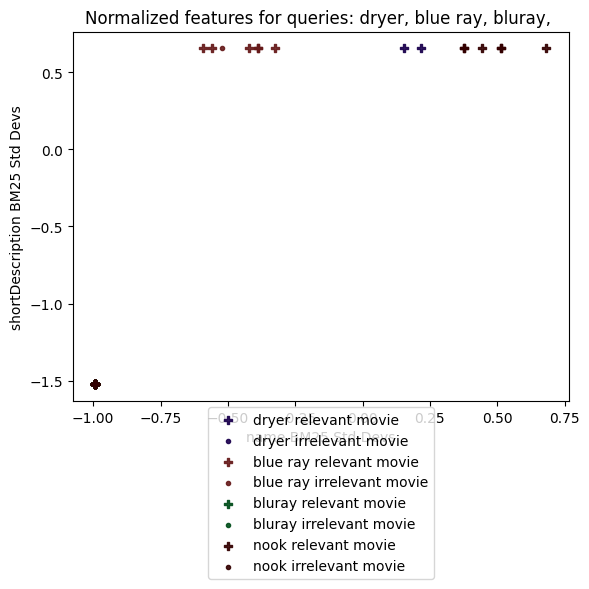

In [15]:
from ltr.plots import plot_judgments

plot_judgments(qids=[0,2,1,9], 
               xlabel="name BM25 Std Devs",
               ylabel="short_description BM25 Std Devs",
               title_prepend="Normalized features for queries:",
               judg_list=normed_judgments)

## Pairwise Transform

Track the difference between relevant / irrelevant docs.

### What you should play with

You can opt to weigh the feature difference by the significance of the grade difference. So very different documents create a very far-apart points in the feature space. Does this change anything? This is controled by the `weigh_difference` parameter to `pairwise_transform`.

In [16]:
import numpy
from ltr.judgments import judgments_from_file, judgments_to_nparray

def pairwise_transform(normed_judgments, weigh_difference = True):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):

        # Annoying issue consuming python iterators, we ensure we have two
        # full copies of each query's judgments
        query_judgments_copy_1 = list(query_judgments) 
        query_judgments_copy_2 = list(query_judgments_copy_1)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if judgment1 more relevant
        # -1 if judgment2 more relevant
        for judgment1 in query_judgments_copy_1:
            for judgment2 in query_judgments_copy_2:
                
                j1_features=numpy.array(judgment1.features)
                j2_features=numpy.array(judgment2.features)
                
                if judgment1.grade > judgment2.grade:
                    diff = judgment1.grade - judgment2.grade if weigh_difference else 1.0
                    predictor_deltas.append(+1)
                    feature_deltas.append(diff * (j1_features-j2_features))
                elif judgment1.grade < judgment2.grade:
                    diff = judgment2.grade - judgment1.grade if weigh_difference else 1.0
                    predictor_deltas.append(-1)
                    feature_deltas.append(diff * (j1_features-j2_features))

    # For training purposes, we return these as numpy arrays
    return numpy.array(feature_deltas), numpy.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

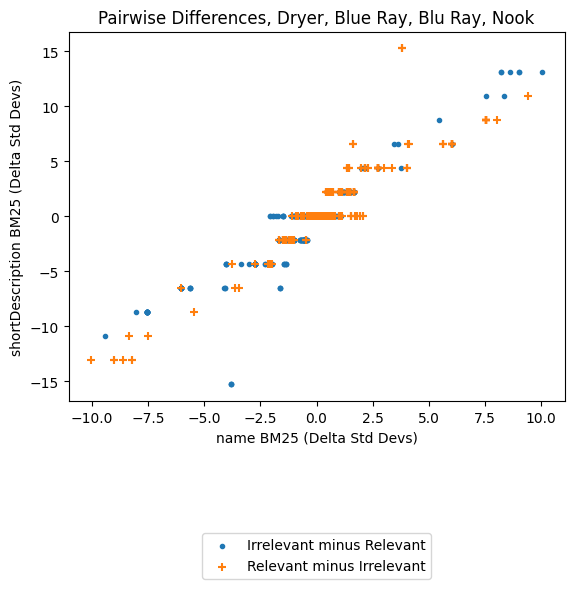

In [17]:
from ltr.plots import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_these_queries = []
for j in normed_judgments:
    if j.qid == 0 or j.qid == 2 or j.qid == 1 or j.qid == 9:
        just_these_queries.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_these_queries)
plot_pairwise_data(features, predictors,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="short_description BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

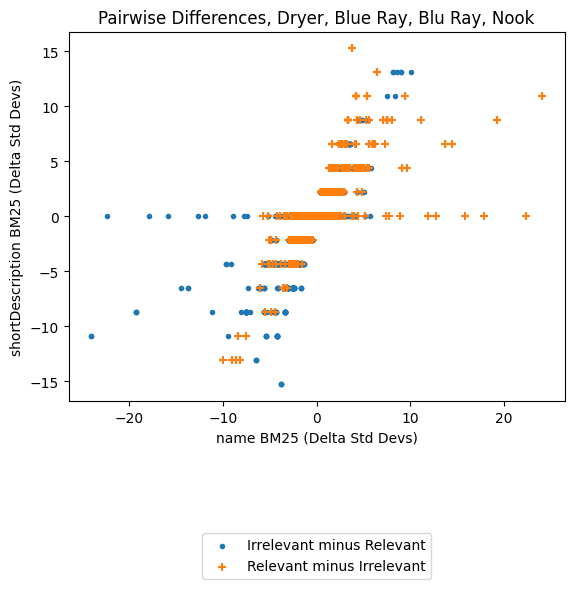

In [18]:
plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="short_description BM25 (Delta Std Devs)",
                   title="Pairwise Differences, Dryer, Blue Ray, Blu Ray, Nook")

## Train the model

We train a linear SVM model here.

### What you should play with

* Play with the various [SVM hyperparameters](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* If you're feeling more advanced: is there a different kind of LTR model you could use?

In [19]:
from sklearn import svm
model = svm.LinearSVC(max_iter=10000, verbose=1)
model.fit(feature_deltas, predictor_deltas)
model.coef_

[LibLinear]

array([[0.07895488, 0.06960982]])

## Upload the model

We upload the model to Solr, using the feature names from our featureset. Nothing to play with here. Of course, if you wanted to explore a non-linear model, you would want to explore the [options available in Solr LTR](https://solr.apache.org/guide/8_8/learning-to-rank.html).

In [20]:
import json

linear_model = {
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
  ],
  "params": {
      "weights": {
      }
  }
}

import math
ftr_model = {}
ftr_names = [ftr['name'] for ftr in feature_set]
for idx, ftr_name in enumerate(ftr_names):
    config = {
        "name": ftr_name,
        "norm": {
            "class": "org.apache.solr.ltr.norm.StandardNormalizer",
            "params": {
                "avg": str(means[idx]),
                "std": str(std_devs[idx])
            }
        }
    }
    linear_model['features'].append(config)
    linear_model['params']['weights'][ftr_name] =  model.coef_[0][idx] 

print(f"PUT {SOLR_URL}/solr/{products_collection}/schema/model-store")
print(json.dumps(linear_model, indent=2))

# Delete old model
resp = requests.delete(f"{SOLR_URL}/solr/{products_collection}/schema/model-store/test_model")


# Upload the model
resp = requests.put(f"{SOLR_URL}/solr/{products_collection}/schema/model-store", json=linear_model)
resp.text

PUT http://aips-solr:8983/solr/solr/products/schema/model-store
{
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
    {
      "name": "name_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "2.1163671514454276",
          "std": "2.1343091696156313"
        }
      }
    },
    {
      "name": "name_constant",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "0.6991150442477876",
          "std": "0.45864277946371484"
        }
      }
    }
  ],
  "params": {
    "weights": {
      "name_bm25": 0.07895487537874991,
      "name_constant": 0.06960982261218789
    }
  }
}


''

## Issue searches!

Issue searches to see if you like the model

### What you should play with

Tune the search to see how deeply to do reranking via `reRankDocs`. Use a different baseline search by adding in [some edismax parameters](https://solr.apache.org/guide/8_8/the-extended-dismax-query-parser.html)

# Figure 11.13

In [21]:
from IPython.display import display,HTML
from aips import render_search_results

query = "transformers dvd"

collection = "products"
request = {
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "q": "{!ltr reRankDocs=60000 reRankWeight=2.0 model=test_model efi.keywords=\"" + query + "\"}",
      "qf": "name upc manufacturer short_description long_description",
      "defType": "edismax",
      "q": query
    }
}

search_results = requests.post(f"{SOLR_URL}/{products_collection}/select", json=request).json()
display(HTML(render_search_results(query, search_results['response']['docs'])))